In [1]:
# STEP 1 — Kaggle setup (local) + download the Mall Customers dataset for clustering

import os, sys, zipfile, subprocess, pathlib, json

# === Fill these from your Kaggle API token (Kaggle -> Account -> Create New API Token) ===
KAGGLE_USERNAME = "iamvijayshankar"
KAGGLE_KEY      = "5432ac578dbd76cbbfa10a1935b6e4aa"
# =========================================================================================

KAGGLE_DATASET = "shwetabh123/mall-customers"   # Mall Customers (great for k-means)
DATA_ROOT      = os.path.abspath("./data")
DATASET_DIR    = os.path.join(DATA_ROOT, "mall_customers")

print("KAGGLE_DATASET:", KAGGLE_DATASET)
print("DATA_ROOT:", DATA_ROOT)
print("DATASET_DIR:", DATASET_DIR)

# 1) Ensure Kaggle CLI is installed in this Python
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)

# 2) Write ~/.kaggle/kaggle.json from creds above (or reuse if already present)
home = str(pathlib.Path.home())
kaggle_dir = os.path.join(home, ".kaggle")
kaggle_json = os.path.join(kaggle_dir, "kaggle.json")
os.makedirs(kaggle_dir, exist_ok=True)
if not KAGGLE_USERNAME or not KAGGLE_KEY:
    raise ValueError("Please set KAGGLE_USERNAME and KAGGLE_KEY (from your kaggle.json).")

with open(kaggle_json, "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
try:
    os.chmod(kaggle_json, 0o600)  # ok if this no-ops on Windows
except Exception:
    pass

# Also set env vars for Kaggle CLI
os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

# 3) Create data folders
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

# 4) Download zip to DATA_ROOT
print("\nDownloading from Kaggle…")
subprocess.run([
    "kaggle", "datasets", "download",
    "-d", KAGGLE_DATASET,
    "-p", DATA_ROOT,
    "--force"
], check=True)

# 5) Unzip every .zip found in DATA_ROOT into DATASET_DIR
for fname in os.listdir(DATA_ROOT):
    if fname.lower().endswith(".zip"):
        zpath = os.path.join(DATA_ROOT, fname)
        print("Unzipping:", zpath)
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(DATASET_DIR)
        os.remove(zpath)

print("\nContents of dataset directory:")
for f in os.listdir(DATASET_DIR):
    print(" -", f)

KAGGLE_DATASET: shwetabh123/mall-customers
DATA_ROOT: /Users/spartan/Documents/data
DATASET_DIR: /Users/spartan/Documents/data/mall_customers

Dataset URL: https://www.kaggle.com/datasets/shwetabh123/mall-customers
License(s): CC0-1.0

Unzipping: /Users/spartan/Documents/data/mall-customers.zip

Contents of dataset directory:
 - Mall_Customers.csv


100%|██████████| 1.56k/1.56k [00:00<00:00, 1.81MB/s]


Loaded file: Mall_Customers.csv
Shape: (200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Missing values:
 CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Duplicate rows (before drop): 0

Using feature columns: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Final matrix for clustering: (200, 3)


,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


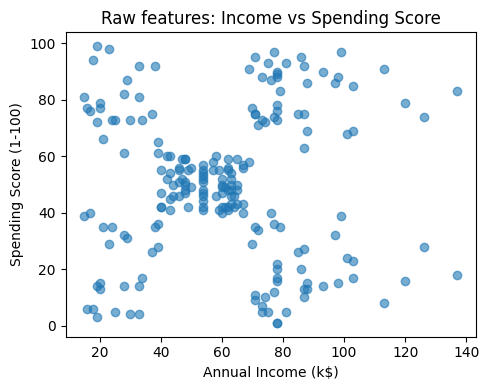

In [2]:
# STEP 2 — Load CSV, sanity checks, pick features (Age/Income/Score), and scale for clustering

import os, glob, re
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Paths (must match Step 1)
DATA_ROOT   = os.path.abspath("./data")
DATASET_DIR = os.path.join(DATA_ROOT, "mall_customers")

# 2.1 Find the CSV robustly (usually "Mall_Customers.csv")
candidates = glob.glob(os.path.join(DATASET_DIR, "*.csv"))
if not candidates:
    raise FileNotFoundError(f"No CSV found in {DATASET_DIR}. Found: {os.listdir(DATASET_DIR)}")
CSV_PATH = candidates[0]
print("Loaded file:", os.path.basename(CSV_PATH))

# 2.2 Read & quick checks
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())

print("\nColumns:", list(df.columns))
print("\nMissing values:\n", df.isna().sum())
print("\nDuplicate rows (before drop):", df.duplicated().sum())

# Drop perfect duplicates if any
if df.duplicated().any():
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New shape:", df.shape)

# 2.3 Identify the 3 core numeric features (be tolerant to small naming differences)
def find_col(patterns):
    for c in df.columns:
        name = c.lower().strip()
        if any(re.search(p, name) for p in patterns):
            return c
    return None

age_col     = find_col([r"\bage\b"])
income_col  = find_col([r"annual", r"income"])
score_col   = find_col([r"spending", r"score"])

if not all([age_col, income_col, score_col]):
    raise ValueError(f"Could not automatically find Age/Income/Score columns. "
                     f"Detected -> age: {age_col}, income: {income_col}, score: {score_col}\n"
                     f"Available columns: {list(df.columns)}")

feature_cols = [age_col, income_col, score_col]
print("\nUsing feature columns:", feature_cols)

# 2.4 Keep only rows with these features present
X = df[feature_cols].copy()
before = len(X)
X = X.dropna(how="any").reset_index(drop=True)
after = len(X)
if after < before:
    print(f"Dropped {before - after} rows with missing values in {feature_cols}")

# Ensure numeric dtype (coerce if needed)
for c in feature_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce")
X = X.dropna().reset_index(drop=True)

# 2.5 Standardize features (important for distance-based clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

print("\nFinal matrix for clustering:", X_scaled_df.shape)
display(X_scaled_df.head())

# 2.6 (Optional) quick visual: pairwise scatter of raw features
plt.figure(figsize=(5,4))
plt.scatter(X[feature_cols[1]], X[feature_cols[2]], alpha=0.6)
plt.xlabel(feature_cols[1]); plt.ylabel(feature_cols[2])
plt.title("Raw features: Income vs Spending Score")
plt.tight_layout()
plt.show()

# Keep these objects for next step:
# df (original), feature_cols, X (raw features), X_scaled (numpy array), X_scaled_df (standardized DataFrame), scaler

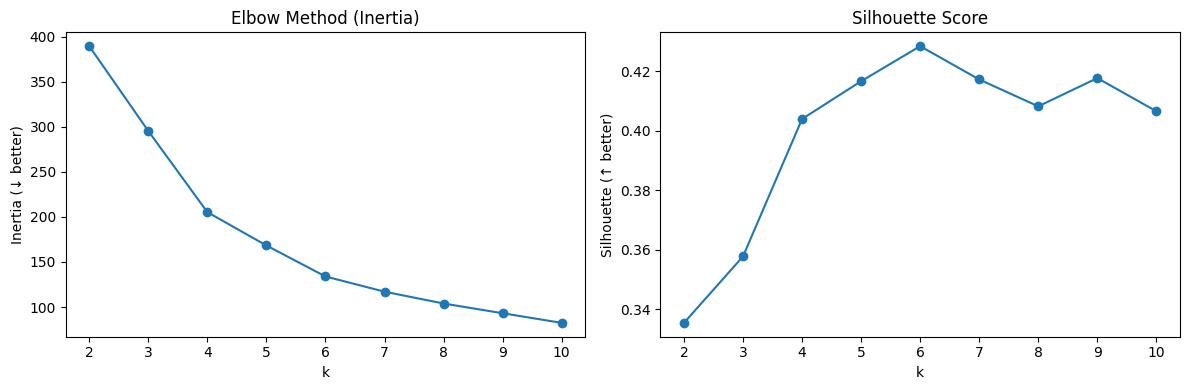

Selected k (by max silhouette): 6  | silhouette=0.428


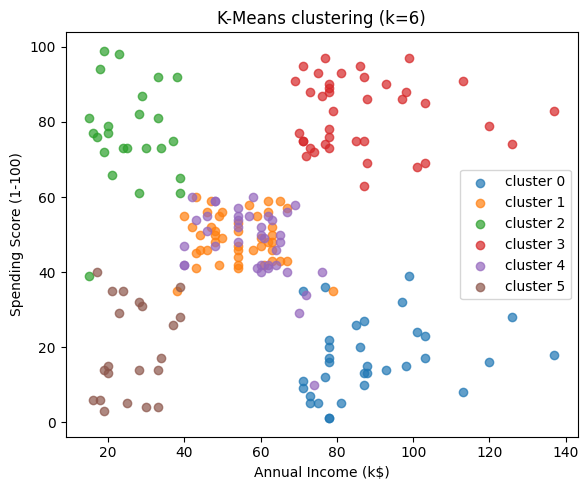


Cluster centers (original units):


,Age,Annual Income (k$),Spending Score (1-100),cluster
0,41.939394,88.939394,16.969697,0
1,56.333333,54.266667,49.066667,1
2,25.250000,25.833333,76.916667,2
3,32.692308,86.538462,82.128205,3
4,26.684211,57.578947,47.789474,4
5,45.523810,26.285714,19.380952,5


Cluster sizes:
  cluster 0: 33
  cluster 1: 45
  cluster 2: 24
  cluster 3: 39
  cluster 4: 38
  cluster 5: 21


In [3]:
# STEP 3 — Pick k (Elbow + Silhouette), fit K-Means, visualize, and show centers (original scale)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 3.1: Try a range of k values
K_RANGE = range(2, 11)  # 2..10
inertias = []
sil_scores = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)    # use standardized features
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# 3.2: Plot Elbow (inertia) and Silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(list(K_RANGE), inertias, marker='o')
ax[0].set_title("Elbow Method (Inertia)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia (↓ better)")

ax[1].plot(list(K_RANGE), sil_scores, marker='o')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette (↑ better)")
plt.tight_layout()
plt.show()

# 3.3: Choose k by best Silhouette (you can override if elbow suggests otherwise)
best_k = int(K_RANGE[int(np.argmax(sil_scores))])
print(f"Selected k (by max silhouette): {best_k}  | silhouette={max(sil_scores):.3f}")

# 3.4: Fit final K-Means with best_k
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# 3.5: Attach cluster labels to dataframes
X_with_clusters = X.copy()
X_with_clusters["cluster"] = cluster_labels

X_scaled_with_clusters = pd.DataFrame(X_scaled, columns=feature_cols)
X_scaled_with_clusters["cluster"] = cluster_labels

# 3.6: Visualize clusters (2D scatter on two most business-relevant features)
xfeat, yfeat = feature_cols[1], feature_cols[2]  # Income vs Spending Score
plt.figure(figsize=(6,5))
for c in sorted(np.unique(cluster_labels)):
    pts = X_with_clusters[X_with_clusters["cluster"] == c]
    plt.scatter(pts[xfeat], pts[yfeat], alpha=0.7, label=f"cluster {c}")
plt.xlabel(xfeat); plt.ylabel(yfeat)
plt.title(f"K-Means clustering (k={best_k})")
plt.legend()
plt.tight_layout()
plt.show()

# 3.7: Show cluster centers in ORIGINAL units (inverse-transform from standardized space)
centers_scaled = kmeans.cluster_centers_
centers_raw = pd.DataFrame(
    scaler.inverse_transform(centers_scaled),
    columns=feature_cols
)
centers_raw["cluster"] = range(best_k)

print("\nCluster centers (original units):")
display(centers_raw)

# 3.8: Quick cluster counts
counts = X_with_clusters["cluster"].value_counts().sort_index()
print("Cluster sizes:")
for c, n in counts.items():
    print(f"  cluster {c}: {n}")

# Keep for next step:
# kmeans, best_k, cluster_labels, X_with_clusters, centers_raw

Silhouette (final k=6): 0.427
Stability (Adjusted Rand Index) over 15 random seeds:
  mean ARI=0.995, std=0.009, min=0.977, max=1.000


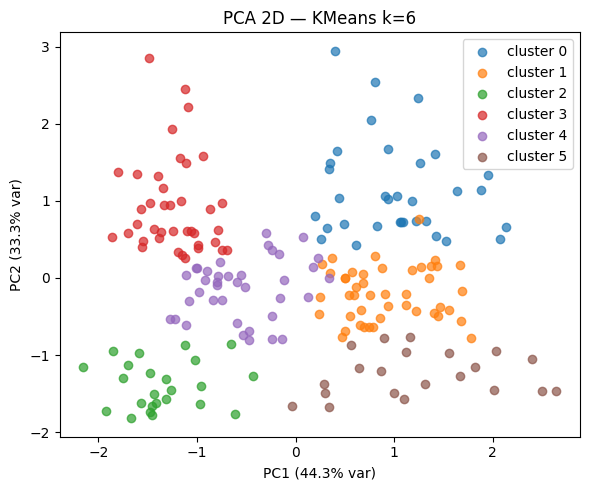


Cluster profile (feature means, original units):


,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,41.939394,88.939394,16.969697
1,1,56.333333,54.266667,49.066667
2,2,25.250000,25.833333,76.916667
3,3,32.692308,86.538462,82.128205
4,4,26.684211,57.578947,47.789474
5,5,45.523810,26.285714,19.380952



✅ Saved labeled data to: ./artifacts/mall_customers_with_clusters.csv  (rows=200)
✅ Saved centers to: ./artifacts/mall_cluster_centers.csv
✅ Saved profile to: ./artifacts/mall_cluster_profile.csv

Summary:
- Best k: 6
- Silhouette: 0.427
- ARI mean±std over 15 trials: 0.995 ± 0.009
- Artifacts: 
  ./artifacts/mall_customers_with_clusters.csv
  ./artifacts/mall_cluster_centers.csv
  ./artifacts/mall_cluster_profile.csv


In [4]:
# STEP 4 — Stability check, PCA visualization, and export tidy artifacts

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans

# 4.1 Stability: compare current clustering to multiple re-fits (different seeds)
n_trials = 15
aris = []
for seed in range(100, 100 + n_trials):
    km_tmp = KMeans(n_clusters=best_k, n_init=20, random_state=seed)
    lbl_tmp = km_tmp.fit_predict(X_scaled)
    ari = adjusted_rand_score(cluster_labels, lbl_tmp)
    aris.append(ari)

sil_final = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette (final k={best_k}): {sil_final:.3f}")
print(f"Stability (Adjusted Rand Index) over {n_trials} random seeds:")
print(f"  mean ARI={np.mean(aris):.3f}, std={np.std(aris):.3f}, min={np.min(aris):.3f}, max={np.max(aris):.3f}")

# 4.2 PCA (2D) for visualization on standardized features
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
for c in sorted(np.unique(cluster_labels)):
    pts = X_pca[cluster_labels == c]
    plt.scatter(pts[:,0], pts[:,1], alpha=0.7, label=f"cluster {c}")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title(f"PCA 2D — KMeans k={best_k}")
plt.legend()
plt.tight_layout()
plt.show()

# 4.3 Cluster profile (means of original units)
profile = X_with_clusters.groupby("cluster")[feature_cols].mean().reset_index()
print("\nCluster profile (feature means, original units):")
display(profile)

# 4.4 Export tidy artifacts
os.makedirs("./artifacts", exist_ok=True)

# (a) Original dataset with cluster labels: align indices safely
out_labels = df.copy()
# Ensure length match; if rows were dropped earlier due to NaNs, align via X index
if len(out_labels) != len(X_with_clusters):
    # Try to merge back by the three selected feature columns (exact matches)
    out_labels = out_labels.merge(
        X_with_clusters,
        on=feature_cols,
        how="inner",
        suffixes=("", "_clust")
    )
    if "cluster" not in out_labels.columns:
        # fallback: use positional match (only if lengths match after dropna)
        if len(df) == len(X_with_clusters):
            out_labels = df.copy()
            out_labels["cluster"] = X_with_clusters["cluster"].values
        else:
            raise ValueError("Could not safely align clusters back to the full df.")
else:
    out_labels["cluster"] = X_with_clusters["cluster"].values

labels_path = "./artifacts/mall_customers_with_clusters.csv"
out_labels.to_csv(labels_path, index=False)
print(f"\n✅ Saved labeled data to: {labels_path}  (rows={len(out_labels)})")

# (b) Cluster centers (original units)
centers_path = "./artifacts/mall_cluster_centers.csv"
centers_raw.to_csv(centers_path, index=False)
print(f"✅ Saved centers to: {centers_path}")

# (c) Cluster profile (means per cluster)
profile_path = "./artifacts/mall_cluster_profile.csv"
profile.to_csv(profile_path, index=False)
print(f"✅ Saved profile to: {profile_path}")

# 4.5 Small summary
print("\nSummary:")
print(f"- Best k: {best_k}")
print(f"- Silhouette: {sil_final:.3f}")
print(f"- ARI mean±std over {n_trials} trials: {np.mean(aris):.3f} ± {np.std(aris):.3f}")
print(f"- Artifacts: \n  {labels_path}\n  {centers_path}\n  {profile_path}")

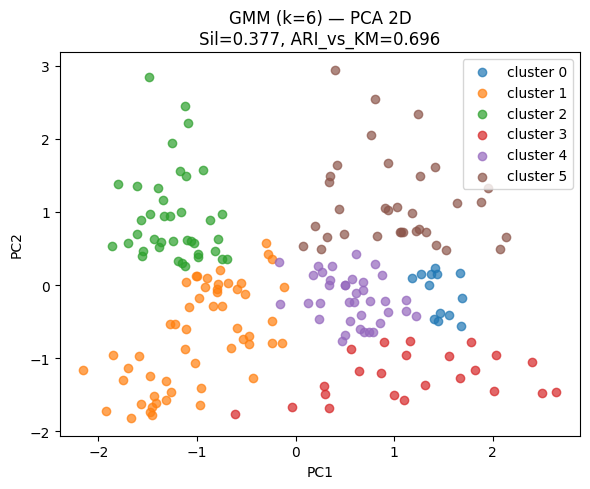

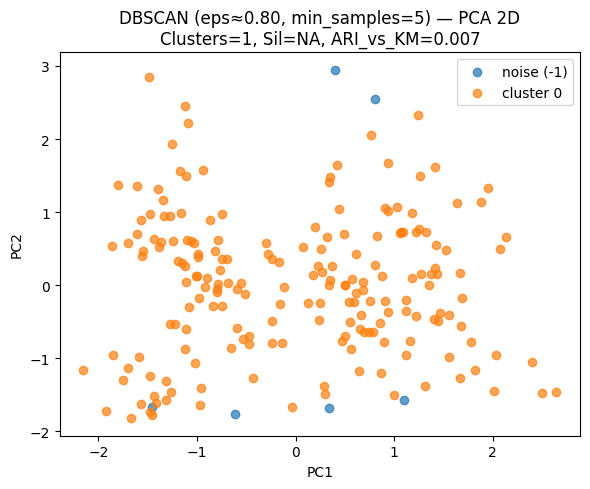

=== Clustering Comparison (higher Silhouette, higher ARI vs K-Means) ===
KMeans           | Silhouette: 0.427 | ARI_vs_KMeans: 1.000
GaussianMixture  | Silhouette: 0.377 | ARI_vs_KMeans: 0.696
DBSCAN           | Silhouette:    NA | ARI_vs_KMeans: 0.007


In [5]:
# STEP 5 — Alternative clustering (Gaussian Mixture + DBSCAN) with metrics & PCA plots

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Reuse: X_scaled, cluster_labels (from K-Means), best_k, and optionally X_pca from Step 4
if 'X_pca' not in globals():
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

results = []

# ---- 5.1 Gaussian Mixture (same k as K-Means) ----
gmm = GaussianMixture(n_components=best_k, covariance_type="full", random_state=42, n_init=5)
gmm_labels = gmm.fit_predict(X_scaled)

sil_gmm = silhouette_score(X_scaled, gmm_labels)
ari_gmm = adjusted_rand_score(cluster_labels, gmm_labels)
results.append(("GaussianMixture", sil_gmm, ari_gmm))

# Plot GMM clusters
plt.figure(figsize=(6,5))
for c in sorted(np.unique(gmm_labels)):
    pts = X_pca[gmm_labels == c]
    plt.scatter(pts[:,0], pts[:,1], alpha=0.7, label=f"cluster {c}")
plt.title(f"GMM (k={best_k}) — PCA 2D\nSil={sil_gmm:.3f}, ARI_vs_KM={ari_gmm:.3f}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 5.2 DBSCAN (density-based; auto-pick eps via 5-NN elbow-ish heuristic) ----
# Heuristic: look at distance to the 5th nearest neighbor, set eps ~ median of those distances
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
k_dist = np.sort(distances[:, -1])          # distance to the k-th neighbor
eps_guess = float(np.percentile(k_dist, 90))  # a generous percentile to avoid all-noise
min_samples = 5

db = DBSCAN(eps=eps_guess, min_samples=min_samples, n_jobs=-1)
db_labels = db.fit_predict(X_scaled)

# Check how many clusters (excluding noise label -1)
db_unique = np.unique(db_labels)
n_db_clusters = len([c for c in db_unique if c != -1])

# Compute metrics only if we have at least 2 clusters
if n_db_clusters >= 2:
    sil_db = silhouette_score(X_scaled, db_labels)
else:
    sil_db = np.nan

# ARI vs K-Means is defined even with noise; ARI ignores label identities
ari_db = adjusted_rand_score(cluster_labels, db_labels)
results.append(("DBSCAN", sil_db, ari_db))

# Plot DBSCAN clusters (noise = -1)
plt.figure(figsize=(6,5))
for c in sorted(db_unique):
    pts = X_pca[db_labels == c]
    label = "noise (-1)" if c == -1 else f"cluster {c}"
    plt.scatter(pts[:,0], pts[:,1], alpha=0.7, label=label)
plt.title(f"DBSCAN (eps≈{eps_guess:.2f}, min_samples={min_samples}) — PCA 2D\n"
          f"Clusters={n_db_clusters}, Sil={sil_db if not np.isnan(sil_db) else 'NA'}, ARI_vs_KM={ari_db:.3f}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 5.3 Compare against K-Means numbers (from Step 3/4) ----
# If you still have sil_final from Step 4; otherwise recompute
try:
    sil_km = sil_final
except NameError:
    sil_km = silhouette_score(X_scaled, cluster_labels)
ari_km = adjusted_rand_score(cluster_labels, cluster_labels)  # 1.0 by definition
results.insert(0, ("KMeans", sil_km, ari_km))

# Print comparison table
print("=== Clustering Comparison (higher Silhouette, higher ARI vs K-Means) ===")
for name, silv, ariv in results:
    sil_str = f"{silv:.3f}" if silv==silv else "NA"   # handle NaN
    print(f"{name:16s} | Silhouette: {sil_str:>5} | ARI_vs_KMeans: {ariv:.3f}")

# Notes:
# - Silhouette measures cluster separation/compactness on current labels.
# - ARI compares two labelings; here we compare GMM/DBSCAN against K-Means labels.
# - DBSCAN can mark outliers as noise (-1) and may produce a variable number of clusters.